In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Get the data
In this notebook we face a regression problem: predicting the cost of a house in California. The dataset used is the `california_housing`, it consists of 20640 records with 8 numerical features:
```
features_name = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
                 'Population', 'AveOccup', 'Latitude', 'Longitude']
```

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [3]:
x_full, y_full = fetch_california_housing(return_X_y=True)
y_full = y_full.reshape((-1,1))
print(x_full.shape, y_full.shape)
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full)
x_train, x_val,  y_train, y_val  = train_test_split(x_train, y_train)

(20640, 8) (20640, 1)


In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train, x_test, x_val = [scaler.transform(x_) for x_ in (x_train, x_test, x_val)]

# Wide and Deep
The following is a simplified version. The original one (described in [this paper](https://arxiv.org/pdf/1606.07792.pdf)) was designed for regression and classification problems with sparse inputs, in particular for recommender systems. The idea is to achieve both memorization (learning of the correlation available in the historical data) and generalization (exploring new feature combinations that have never or rarely occurred in the past) by combining together wide and deep models.
### Define the model

In [8]:
from tensorflow.keras.layers import Input, Dense, Concatenate

inputs  = Input(shape=[x_train.shape[1]])
hidden1 = Dense(20, activation="relu")(inputs)
hidden2 = Dense(10, activation="relu")(hidden1)
hidden3 = Dense(10, activation="relu")(hidden2)
concat  = Concatenate()([hidden1, hidden3])
outputs = Dense(1, activation=None)(concat)

wide_dp = tf.keras.Model(inputs=[inputs], outputs=outputs)

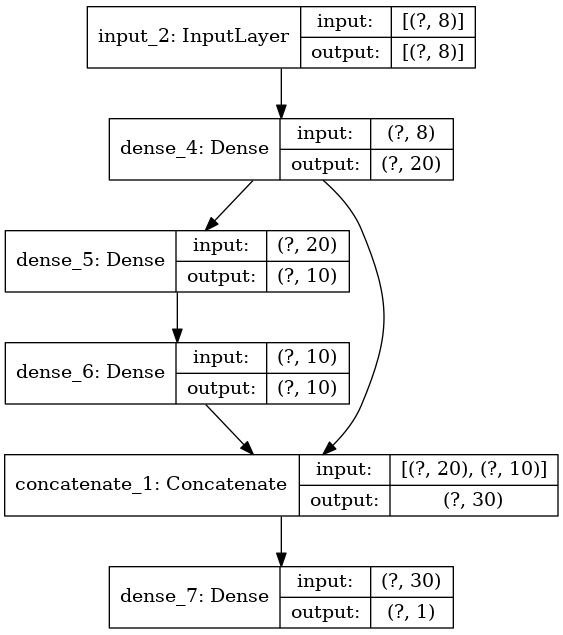

In [9]:
tf.keras.utils.plot_model(wide_dp, show_shapes=True)

### Training

In [10]:
wide_dp.compile(loss='mse', optimizer='sgd')
history = wide_dp.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7660 - val_loss: 0.5841
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6236 - val_loss: 0.6450
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6357 - val_loss: 1.8880
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4544 - val_loss: 0.4270
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4826 - val_loss: 0.4343
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4429 - val_loss: 0.3977
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3783 - val_loss: 0.3831
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3818 - val_loss: 0.3781
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3705 - val_loss: 0.3767
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3613 - val_loss: 0.3696

Text(0.5, 0, 'Epoch')

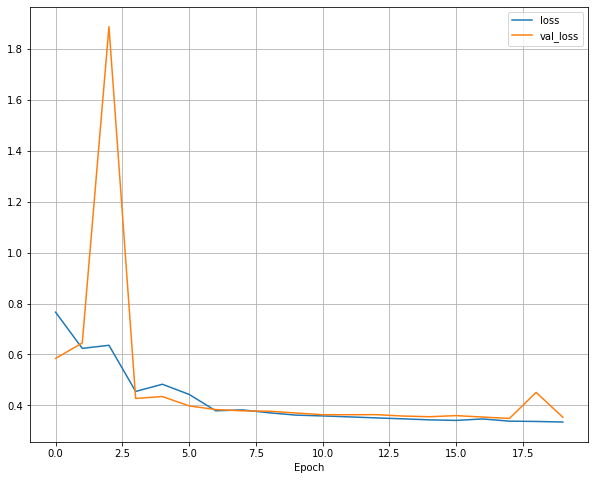

In [11]:
plt.figure(figsize=(10,8))
for k, v in history.history.items():
    plt.plot(v, label=k)
plt.legend()
plt.grid()
plt.xlabel('Epoch')

### Evaluation

In [12]:
test_loss = wide_dp.evaluate(x_test, y_test)
print("Test loss    : %.3f"%test_loss)

162/162 [==============================] - 0s 1ms/step - loss: 0.3448
Test loss    : 0.345


# Multiple Inputs
Suppose to have better insights into the data and to know that some features present simple patterns while other need more complex transformations. We can split the inputs and create two different paths.

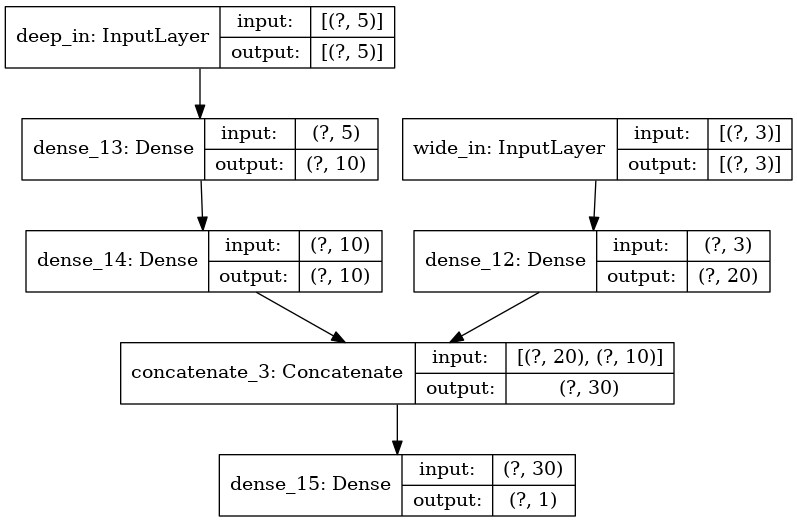

In [14]:
from tensorflow.keras.layers import Input, Dense, Concatenate

wide_feats = 3

inputs_w = Input(shape=[wide_feats], name='wide_in')
inputs_d = Input(shape=[x_train.shape[1] - wide_feats], name='deep_in')
hidden1 = Dense(20, activation="relu")(inputs_w)
hidden2 = Dense(10, activation="relu")(inputs_d)
hidden3 = Dense(10, activation="relu")(hidden2)
concat  = Concatenate()([hidden1, hidden3])
outputs = Dense(1, activation=None)(concat)

multi_input = tf.keras.Model(inputs=[inputs_w, inputs_d], outputs=outputs)
tf.keras.utils.plot_model(multi_input, show_shapes=True)

In [15]:
multi_input.compile(loss='mse', optimizer='sgd')
history = multi_input.fit(x={'wide_in': x_train[:,:wide_feats], 'deep_in': x_train[:,wide_feats:]},
                          y=y_train,
                          epochs=30,
                          validation_data=((x_val[:,:wide_feats], x_val[:,wide_feats:]), y_val))

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 0.9501 - val_loss: 0.5792
Epoch 2/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5924 - val_loss: 0.5672
Epoch 3/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5381 - val_loss: 0.5274
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5103 - val_loss: 0.4887
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4731 - val_loss: 0.4638
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4537 - val_loss: 0.4974
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4346 - val_loss: 0.4341
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4176 - val_loss: 0.4179
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4066 - val_loss: 0.4047
Epoch 10/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3981 - val_loss: 0.4023

Text(0.5, 0, 'Epoch')

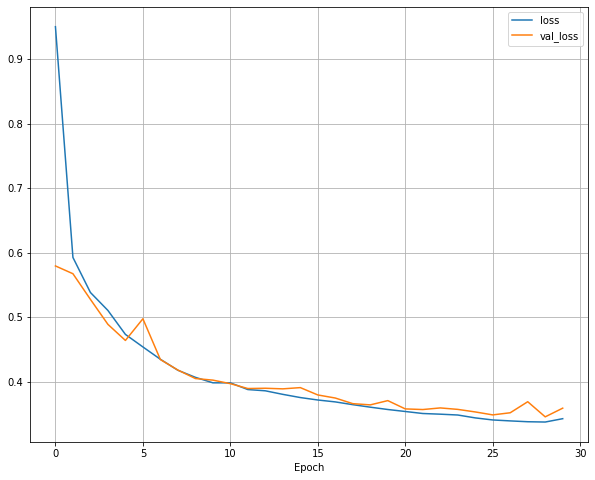

In [16]:
plt.figure(figsize=(10,8))
for k, v in history.history.items():
    plt.plot(v, label=k)
plt.legend()
plt.grid()
plt.xlabel('Epoch')

### Evaluation

In [17]:
test_loss = multi_input.evaluate({'wide_in':x_test[:,:wide_feats], 'deep_in':x_test[:,wide_feats:]}, y_test)
print("Test loss    : %.3f"%test_loss)

162/162 [==============================] - 0s 1ms/step - loss: 0.3483
Test loss    : 0.348


### Predictions

In [18]:
multi_input({'deep_in':x_val[:,wide_feats:], 'wide_in':x_val[:,:wide_feats]})

<tf.Tensor: shape=(3870, 1), dtype=float32, numpy=
array([[3.7739646],
       [1.3034033],
       [1.1543014],
       ...,
       [2.3096454],
       [4.2078357],
       [1.9406226]], dtype=float32)>